In [10]:
%reset -f

# ==============
# DEVICE SETUP 
# ==============

# Core libraries
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np

# Progress bar for notebooks
from tqdm.notebook import tqdm 

# Astronomy libraries
from astropy.time import Time
from astropy.coordinates import get_body_barycentric
import astropy.units as u

# Set random seeds for reproducibility
torch.manual_seed(1234)
np.random.seed(1234)

# Device-agnostic configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Working on {device}")

# Device-specific optimizations
if device.type == 'cuda':
    print(f"  GPU: {torch.cuda.get_device_name()}")
    print(f"  CUDA Version: {torch.version.cuda if hasattr(torch.version, 'cuda') else 'Unknown'}")
    print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    
    # Enable CUDNN optimizations for consistent input sizes
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True
    
    # Set memory allocation strategy
    torch.cuda.empty_cache()
else:
    print("  Using CPU with optimized threading")
    # CPU optimizations
    torch.set_num_threads(torch.get_num_threads())
    print(f"  CPU Threads: {torch.get_num_threads()}")

# General optimizations (CPU and GPU)
torch.backends.cudnn.deterministic = False  # Allow non-deterministic for speed
torch.autograd.set_detect_anomaly(False)    # Disable anomaly detection for speed

🚀 Working on cpu
  Using CPU with optimized threading
  CPU Threads: 4


In [11]:
# ===============================================================================
# ORBITAL MECHANICS FUNCTIONS
# ===============================================================================

def solve_kepler(M: np.ndarray, e: float, tol: float = 1e-10, maxiter: int = 10) -> np.ndarray:
    """
    Solve Kepler's equation for elliptic orbits using Newton-Raphson method.
    
    Args:
        M: Mean anomaly [rad]
        e: Eccentricity
        tol: Convergence tolerance
        maxiter: Maximum iterations
        
    Returns:
        E: Eccentric anomaly [rad]
    """
    M = np.asarray(M)
    E = M.copy()
    
    for _ in range(maxiter):
        f = E - e * np.sin(E) - M
        fp = 1 - e * np.cos(E)
        dE = -f / fp
        E += dE
        if np.all(np.abs(dE) < tol):
            break
    return E


def keplerian_to_cartesian(kepler_coord: np.ndarray, mu_param: float = 1.) -> tuple:
    """
    Convert Keplerian elements to Cartesian coordinates.
    
    Args:
        kepler_coord: [a, e, i, Omega, omega, M] in [AU, -, rad, rad, rad, rad]
        mu_param: Gravitational parameter [AU³/day²]
        
    Returns:
        r, v: Position [AU] and velocity [AU/day] in heliocentric ECI frame
    """
    a, e, i, Omega, omega, M = kepler_coord
    mu_use = mu_param if mu_param is not None else mu
    
    # Solve Kepler's equation
    E = solve_kepler(M, e)
    
    # True anomaly
    nu = 2 * np.arctan2(np.sqrt(1 + e) * np.sin(E / 2), 
                        np.sqrt(1 - e) * np.cos(E / 2))
    
    # Distance from central body
    r_norm = a * (1 - e * np.cos(E))
    
    # Position and velocity in perifocal frame
    cos_nu, sin_nu = np.cos(nu), np.sin(nu)
    sin_E, cos_E = np.sin(E), np.cos(E)
    
    r_pqw = r_norm * np.array([cos_nu, sin_nu, 0])
    v_pqw = (np.sqrt(mu_use * a) / r_norm * 
             np.array([-sin_E, np.sqrt(1 - e**2) * cos_E, 0]))
    
    # Rotation matrix elements (optimized)
    cos_Om, sin_Om = np.cos(Omega), np.sin(Omega)
    cos_w, sin_w = np.cos(omega), np.sin(omega)
    cos_i, sin_i = np.cos(i), np.sin(i)
    
    # Perifocal to ECI transformation
    R = np.array([
        [cos_Om*cos_w - sin_Om*sin_w*cos_i, -cos_Om*sin_w - sin_Om*cos_w*cos_i,  sin_Om*sin_i],
        [sin_Om*cos_w + cos_Om*sin_w*cos_i, -sin_Om*sin_w + cos_Om*cos_w*cos_i, -cos_Om*sin_i],
        [sin_w*sin_i,                        cos_w*sin_i,                        cos_i]
    ])
    
    return R @ r_pqw, R @ v_pqw


def keplerian_to_obs(kepler_coord: np.ndarray, r_obs: np.ndarray = np.zeros(3), 
                     v_obs: np.ndarray = np.zeros(3), mu_param: float = 1.) -> tuple:
    """
    Convert Keplerian elements to observational quantities.
    
    Args:
        kepler_coord: [a, e, i, Omega, omega, M]
        r_obs: Observatory position [AU]
        v_obs: Observatory velocity [AU/day]
        mu_param: Gravitational parameter [AU³/day²]
        
    Returns:
        alpha, delta, alpha_dot, delta_dot, rho, rho_dot: Observables
    """
    # Get heliocentric Cartesian coordinates
    r_ast, v_ast = keplerian_to_cartesian(kepler_coord, mu_param)
    
    # Topocentric vectors
    rho_vec = r_ast - r_obs
    v_rel = v_ast - v_obs
    
    rho = np.linalg.norm(rho_vec)
    hat_rho = rho_vec / rho
    rho_dot = np.dot(hat_rho, v_rel)
    
    # Angular quantities
    rho_hat_dot = (v_rel - rho_dot * hat_rho) / rho
    
    alpha = np.arctan2(hat_rho[1], hat_rho[0])
    delta = np.arcsin(hat_rho[2])
    
    # Angular rates
    denom = hat_rho[0]**2 + hat_rho[1]**2
    alpha_dot = (hat_rho[0]*rho_hat_dot[1] - hat_rho[1]*rho_hat_dot[0]) / denom
    delta_dot = rho_hat_dot[2] / np.cos(delta)
    
    return alpha, delta, alpha_dot, delta_dot, rho, rho_dot


def equinoctial_to_cartesian(equin_coord: np.ndarray, mu_param: float = 1.) -> tuple:
    """
    Convert equinoctial elements to Cartesian coordinates.
    
    Args:
        equin_coord: [a, h, k, p, q, lambda] with a in [AU]
        mu_param: Gravitational parameter [AU³/day²]
        
    Returns:
        r, v: Position [AU] and velocity [AU/day] in heliocentric ECI frame
    """
    a, h, k, p, q, l = equin_coord
    mu_use = mu_param if mu_param is not None else mu
    
    # Derived quantities
    e = np.sqrt(h**2 + k**2)
    omega_plus_Omega = np.arctan2(h, k)
    i = 2 * np.arctan(np.sqrt(p**2 + q**2))
    Omega = np.arctan2(p, q)
    
    # Mean anomaly and eccentric anomaly
    M = np.mod(l - omega_plus_Omega, 2*np.pi)
    E = solve_kepler(M, e)
    
    # True anomaly
    nu = 2 * np.arctan2(np.sqrt(1+e)*np.sin(E/2), np.sqrt(1-e)*np.cos(E/2))
    
    # Perifocal coordinates
    r_pqw_norm = a * (1 - e*np.cos(E))
    cos_nu, sin_nu = np.cos(nu), np.sin(nu)
    sin_E, cos_E = np.sin(E), np.cos(E)
    
    r_vec_pqw = r_pqw_norm * np.array([cos_nu, sin_nu, 0])
    v_vec_pqw = (np.sqrt(mu_use * a) / r_pqw_norm * 
                 np.array([-sin_E, np.sqrt(1 - e**2)*cos_E, 0]))
    
    # Rotation matrix
    omega = omega_plus_Omega - Omega
    cos_Om, sin_Om = np.cos(Omega), np.sin(Omega)
    cos_w, sin_w = np.cos(omega), np.sin(omega)
    cos_i, sin_i = np.cos(i), np.sin(i)
    
    R = np.array([
        [cos_Om*cos_w - sin_Om*sin_w*cos_i, -cos_Om*sin_w - sin_Om*cos_w*cos_i, sin_Om*sin_i],
        [sin_Om*cos_w + cos_Om*sin_w*cos_i, -sin_Om*sin_w + cos_Om*cos_w*cos_i, -cos_Om*sin_i],
        [sin_w*sin_i,                        cos_w*sin_i,                       cos_i]
    ])
    
    return R @ r_vec_pqw, R @ v_vec_pqw


def equinoctial_to_obs(equin_coord: np.ndarray, r_obs: np.ndarray = np.zeros(3), 
                       v_obs: np.ndarray = np.zeros(3), mu_param: float = 1.) -> tuple:
    """Convert equinoctial elements to observational quantities."""
    r_ast, v_ast = equinoctial_to_cartesian(equin_coord, mu_param)
    
    # Topocentric vectors
    rho_vec = r_ast - r_obs
    v_rel = v_ast - v_obs
    
    rho = np.linalg.norm(rho_vec)
    hat_rho = rho_vec / rho
    rho_dot = np.dot(hat_rho, v_rel)
    
    # Angular quantities
    rho_hat_dot = (v_rel - rho_dot * hat_rho) / rho
    
    alpha = np.arctan2(hat_rho[1], hat_rho[0])
    delta = np.arcsin(hat_rho[2])
    
    # Angular rates
    denom = hat_rho[0]**2 + hat_rho[1]**2
    alpha_dot = (hat_rho[0]*rho_hat_dot[1] - hat_rho[1]*rho_hat_dot[0]) / denom
    delta_dot = rho_hat_dot[2] / np.cos(delta)
    
    return alpha, delta, alpha_dot, delta_dot, rho, rho_dot

In [12]:
# Physical constants and parameters
AU =  149597870.7 # km per Au
DAY = 60*60*24 # seconds per day

MU_SUN_KM = 1.32712440018e11  # km³/s² (Sun's gravitational parameter)
mu = MU_SUN_KM * (DAY**2) / (AU**3)  # Convert to AU³/day² for consistency with the .csv dataset

print(f"Using Solar μ = {mu:.6e} AU³/day² for orbital calculations")

# ===============================================================================  
# IMPROVED EARTH POSITION CALCULATION FOR ACCURATE NEO RANGES IPORTING
# ===============================================================================

def get_earth_position_simple(t_mjd: float) -> tuple:
    """
    Get approximate Earth position and velocity at given MJD time.
    Uses simplified circular orbit approximation.
    
    Args:
        t_mjd: Modified Julian Date
        
    Returns:
        (r_earth, v_earth): Position [AU] and velocity [AU/day] vectors
    """
    # Convert MJD to days since J2000.0
    t_j2000 = t_mjd - 51544.5
    
    # Earth's mean motion (rad/day) - approximately 2π/365.25
    n_earth = 2 * np.pi / 365.25
    
    # Earth's mean anomaly at time t
    M = n_earth * t_j2000
    
    # Simplified circular orbit (Earth eccentricity ≈ 0.017, neglected)
    r_earth = np.array([
        np.cos(M),      # x component [AU]
        np.sin(M),      # y component [AU] 
        0.0             # z component [AU]
    ])
    
    v_earth = np.array([
        -n_earth * np.sin(M),   # vx [AU/day]
        n_earth * np.cos(M),    # vy [AU/day]
        0.0                     # vz [AU/day]
    ])
    
    return r_earth, v_earth

Using Solar μ = 2.959122e-04 AU³/day² for orbital calculations


In [13]:
# ===============================================================================
# DATA LOADING AND PREPROCESSING
# ===============================================================================

# Reference time for observations (MJD)
T_0_MJD = 60800.0
t_0 = torch.tensor([T_0_MJD], dtype=torch.float32, device=device)


def load_dataset_from_csv(filepath: str = 'DataSet_NEO_VSA_from1to8nights.csv') -> tuple:
    """
    Load NEO dataset from CSV file and convert to PyTorch tensors.
    
    Args:
        filepath: Path to the CSV file
        
    Returns:
        Tuple of tensors: (t_domain, x_domain, y_domain, t_0, x_0, y_0)
    """
    try:
        df = pd.read_csv(filepath)
        print(f"📄 Successfully loaded {filepath}. Shape: {df.shape}")
    except FileNotFoundError:
        print(f"❌ Error: File {filepath} not found.")
        return tuple(torch.empty(0) for _ in range(6))
    
    # Column definitions
    input_cols = ['alpha', 'delta', 'alpha_dot', 'delta_dot']
    kepler_cols = ['a_kep', 'e', 'i', 'Omega', 'omega', 'M']
    equin_cols = ['a_equ', 'h', 'k', 'p', 'q', 'lambda']
    
    # Storage lists
    data_lists = {
        't': [], 'x': [], 'y': [],
        't_0': [], 'x_0': [], 'y_0': []
    }
    
    # Process each row
    for idx, row in df.iterrows():
        try:
            # Extract data
            x_features = row[input_cols].values
            t_fit = row['t_fit']
            
            # Fix: Convert to numpy arrays properly
            equin_params = row[equin_cols].values.astype(np.float64)
            kepler_params = row[kepler_cols].values.astype(np.float64)
            
            # CRITICAL FIX: Get Earth's position at observation time
            earth_r, earth_v = get_earth_position_simple(t_fit)
            
            # Convert to observables WITH EARTH AS OBSERVER
            va_0 = equinoctial_to_obs(equin_params, r_obs=earth_r, v_obs=earth_v, mu_param=mu)
            va_true = keplerian_to_obs(kepler_params, r_obs=earth_r, v_obs=earth_v, mu_param=mu)
            
            # Check for NaN or infinite values
            if np.any(np.isnan(va_0)) or np.any(np.isnan(va_true)):
                print(f"⚠️  Warning: NaN values found in row {idx}, skipping")
                continue
            if np.any(np.isinf(va_0)) or np.any(np.isinf(va_true)):
                print(f"⚠️  Warning: Infinite values found in row {idx}, skipping")
                continue
            # Check for valid MJD range
            if not (15020 <= t_fit <= 88069):
                print(f"⚠️  Skipping row {idx} with invalid MJD: {t_fit}")
                continue
            # Check for negative range (physically impossible)
            if va_0[4] <= 0 or va_true[4] <= 0:
                print(f"⚠️  Warning: Negative range found in row {idx}, skipping")
                continue
                
            # Store data
            data_lists['x'].append(x_features.tolist())
            data_lists['t'].append(float(t_fit))
            data_lists['y'].append([float(va_true[4]), float(va_true[5])])  # rho, rho_dot
            
            data_lists['x_0'].append([float(va_0[0]), float(va_0[1]), float(va_0[2]), float(va_0[3])])  # angles
            data_lists['t_0'].append(float(T_0_MJD))
            data_lists['y_0'].append([float(va_0[4]), float(va_0[5])])  # rho, rho_dot
            
        except Exception as e:
            print(f"❌ Error processing row {idx}: {e}")
            continue
    
    # Check if data was loaded
    if len(data_lists['y']) == 0:
        print("❌ No valid data loaded!")
        return tuple(torch.empty(0) for _ in range(6))
    
    print(f"✅ Loaded {len(data_lists['y'])} valid data points")
    
    # Convert to tensors with debugging
    tensors = {}
    for key, data in data_lists.items():
        try:
            array = np.array(data, dtype=np.float32)
            tensors[key] = torch.tensor(array, device=device)
        except Exception as e:
            print(f"❌ Error creating tensor for {key}: {e}")
            tensors[key] = torch.empty(0, device=device)
    
    return (tensors['t'], tensors['x'], tensors['y'], 
            tensors['t_0'], tensors['x_0'], tensors['y_0'])

In [14]:
# ===============================================================================
# CHARACTERISTIC SCALES AND NORMALIZATION
# ===============================================================================

'''
# Characteristic quantities (based NEO typical scales)
L_c = 1.0e8  # km (typical NEO distance ~100 million km)
T_c = np.sqrt(L_c**3 / MU_SUN_KM)  # seconds
V_c = L_c / T_c  # km/s
'''

'''
# Characteristic quantities (based on lunar orbit)
L_c = 3.844e5  # km (mean orbital radius of the moon)
T_c = np.sqrt(L_c**3 / MU_SUN_KM)  # seconds (characteristic time)
V_c = L_c / T_c  # km/s (characteristic velocity)
'''

# Characteristic quantities (based on earth orbit)
L_c = 1.496e8  # km (mean orbital radius of the earth)
T_c = np.sqrt(L_c**3 / MU_SUN_KM)  # seconds (characteristic time)
V_c = L_c / T_c  # km/s (characteristic velocity)

mu_dimensionless = (MU_SUN_KM * T_c**2) / (L_c**3)

print(f"Characteristic scales:")
print(f"  L_c = {L_c:.0e} km")
print(f"  T_c = {T_c:.0e} s = {T_c/DAY:.2f} days")
print(f"  V_c = {V_c:.2f} km/s")


def normalize(inputs: torch.Tensor, export_minmax: bool = False) -> 'torch.Tensor | tuple[torch.Tensor, torch.Tensor, torch.Tensor]':
    """
    Normalize inputs to [-1, 1] range.
    
    Args:
        inputs: Input tensor
        export_minmax: Whether to return min/max values
        
    Returns:
        Normalized tensor, optionally with min/max values
    """
    inputs_min = inputs.min(dim=0, keepdim=True).values
    inputs_max = inputs.max(dim=0, keepdim=True).values
    
    normalized = 2 * (inputs - inputs_min) / (inputs_max - inputs_min + 1e-8) - 1
    
    if export_minmax:
        return normalized, inputs_min, inputs_max
    else:
        return normalized


def denormalize(inputs: torch.Tensor, inputs_min: torch.Tensor, 
                inputs_max: torch.Tensor) -> torch.Tensor:
    """Denormalize from [-1, 1] to original scale."""
    return ((inputs + 1) / 2) * (inputs_max - inputs_min + 1e-8) + inputs_min


def non_dimensionalise(x: torch.Tensor, t: torch.Tensor, y: torch.Tensor) -> tuple:
    """
    Convert physical quantities to dimensionless form.
    
    Args:
        x: Angular observables [alpha, delta, alpha_dot, delta_dot]
        t: Time observations [MJD]
        y: Range observables [rho, rho_dot] in [AU, AU/day]
        
    Returns:
        Tuple of dimensionless tensors (x_nodim, t_nodim, y_nodim)
    """
    # Angular quantities (already dimensionless, convert rates)
    x_nodim = torch.empty_like(x)
    x_nodim[:, 0] = x[:, 0]  # alpha [rad]
    x_nodim[:, 1] = x[:, 1]  # delta [rad]
    x_nodim[:, 2] = (x[:, 2] / DAY) * T_c  # alpha_dot [rad/day] --> alpha_dot [rad/s] --> dimensionless
    x_nodim[:, 3] = (x[:, 3] / DAY) * T_c  # delta_dot [rad/day] --> delta_dot [rad/s] --> dimensionless

    # Time conversion: MJD --> dimensionless
    t_mjd = t - T_0_MJD  # Offset from reference time
    t_sec = t_mjd * DAY  # Convert to seconds
    t_nodim = (t_sec / T_c).view(-1, 1)  # Make dimensionless
    
    # Range quantities: AU --> dimensionless
    y_nodim = torch.empty_like(y)
    y_nodim[:, 0] = (y[:, 0] * AU) / L_c      # rho [AU] --> rho [km] --> dimensionless
    y_nodim[:, 1] = (y[:, 1] * AU / DAY) / V_c  # rho_dot [AU/day] --> rho_dot [km/s] --> dimensionless
    
    return x_nodim, t_nodim, y_nodim

Characteristic scales:
  L_c = 1e+08 km
  T_c = 5e+06 s = 58.13 days
  V_c = 29.78 km/s


In [15]:
# ===============================================================================
# NEURAL NETWORK SUPPORT CLASSES
# ===============================================================================

class FourierEmbedding(nn.Module):
    """
    Fourier feature embedding for improved neural network training.
    Maps input features to higher-dimensional space using random Fourier features.
    """
    
    def __init__(self, in_dim: int, mapping_size: int, scale: float):
        """
        Initialize Fourier embedding.
        
        Args:
            in_dim: Input dimension
            mapping_size: Number of random features
            scale: Scale of random Fourier features
        """
        super().__init__()
        self.register_buffer('B', torch.randn(in_dim, mapping_size) * scale)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Apply Fourier embedding to input."""
        B = self.B.to(x.device).to(x.dtype)
        x_proj = 2 * np.pi * x @ B
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

In [16]:
# ===============================================================================
# PHYSICS-INFORMED NEURAL NETWORK FOR VERY SHORT ARCS
# ===============================================================================

class PINN_VSA(nn.Module):
    """
    Physics-Informed Neural Network for Very Short Arc (VSA) orbit determination.
    
    Coordinate System Handling:
    - Input attributable elements produce GEOCENTRIC coordinates (Earth-centered)
    - Physical constraints (energy, angular momentum) computed in HELIOCENTRIC frame
    - All coordinate transformations handled consistently
    """
    
    def __init__(self, layers: list, loss_type: str, n_batch: int, mu: float, 
                 t0_mjd: float, *data, fourier_m: int, fourier_scale: float, corners: list):
        """
        Initialize PINN_VSA model.
        
        Args:
            layers: Network architecture [input_size, hidden_sizes..., output_size]
            loss_type: Loss function type ('mse' or 'logcosh')
            n_batch: Batch size
            mu: Gravitational parameter
            t0_mjd: Reference time (MJD)
            t_edges: Time domain corners for normalization
            data: Training data (t0, x0, y0, t_domain, x_domain, y_domain)
            fourier_m: Fourier embedding size
            fourier_scale: Fourier embedding scale
        """
        super().__init__()
        
        # Network configuration
        self.fourier = FourierEmbedding(in_dim=5, mapping_size=fourier_m, scale=fourier_scale)
        L0 = 2 * fourier_m  # Input size after Fourier embedding
        layers = [L0] + layers[1:]
        
        # Physical parameters
        self.mu = mu
        self.losstype = loss_type
        self.n_batch = n_batch
        
        # Time parameters
        self.t0_mjd = t0_mjd
        #self.t_edges = t_edges
        self._earth_position_cache = {}
        
        # Setup data loaders
        self._setup_data_loaders(*data, corners=corners)
        
        # Setup network layers with factorized weights
        self._setup_network_layers(layers)
        
        # Training configuration
        self._setup_training_config()

    def _setup_data_loaders(self, t_domain, x_domain, y_domain, t0, x0, y0, corners: list):
        """Setup data loaders for training, validation, and initial conditions."""
        self.n_data = len(t_domain)
        n_train = max(1, int(0.6 * self.n_data))  # 60% for training
        
        # Training data
        self.train_dataset = TensorDataset(
            x_domain[:n_train], t_domain[:n_train], y_domain[:n_train]
        )
        self.train_loader = DataLoader(self.train_dataset, batch_size=self.n_batch, shuffle=True)
        
        # Initial conditions
        self.ic_dataset = TensorDataset(x0, t0, y0)
        self.ic_loader = DataLoader(self.ic_dataset, batch_size=self.n_batch, shuffle=True)
        
        # Validation data
        self.x_valid = x_domain[n_train:]
        self.t_valid = t_domain[n_train:]
        self.y_valid = y_domain[n_train:]
        self.valid_dataset = TensorDataset(self.x_valid, self.t_valid, self.y_valid)
        self.valid_loader = DataLoader(self.valid_dataset, batch_size=self.n_batch, shuffle=True)
        
		# Border corners for physical data
        self.t_border = [corners[0], corners[1]]
        self.x_border = [corners[2], corners[3]]
        self.y_border = [corners[4], corners[5]]

    def _setup_network_layers(self, layers):
        """Setup network layers with factorized weights for better optimization."""
        self.layers = nn.ModuleList()
        self.activation = nn.Tanh()
        
        # Weight factorization parameters
        self.s_list = {}
        self.v_list = {}
        biases = []
        
        for i in range(len(layers) - 1):
            # Create linear layer
            self.layers.append(nn.Linear(layers[i], layers[i+1], bias=True))
            
            # Factorize weights: W = s * v
            W = self.layers[-1].weight.detach().clone()
            s = torch.exp(torch.randn(layers[i+1]) * 0.1 + 1.0)
            v = W / s.unsqueeze(1)
            
            # Register factorized parameters
            self.s_list[f"s_{i}"] = nn.Parameter(s, requires_grad=True)
            self.v_list[f"v_{i}"] = nn.Parameter(v, requires_grad=True)
            self.register_parameter(f"s_{i}", self.s_list[f"s_{i}"])
            self.register_parameter(f"v_{i}", self.v_list[f"v_{i}"])
            
            biases.append(self.layers[-1].bias.requires_grad_(True))
            
            # Freeze original weights
            self.layers[i].weight.requires_grad_(False)
            self.layers[i].bias.requires_grad_(False)
        
        self.new_param = (list(self.s_list.values()) + 
                         list(self.v_list.values()) + biases)
    

    def _setup_training_config(self):
        """Setup training configuration and loss weighting."""
        self.optimizer = None
        self.train_loss_history = []
        
        # Loss weighting parameters
        self.n_losses = 5  # IC, PDE, residual, interstellar, surface_revolution
        self.loss_weights = torch.ones(self.n_losses, device=device, requires_grad=False)
        self.f = 20  # Frequency for weight updates
        self.alpha = 0.91  # Exponential moving average factor
    

    # --------------------------------- Core Methods -------------------------------------------------
    def get_factorized_weight(self, i: int) -> tuple:
        """Get factorized weight and bias for layer i."""
        s = self.s_list[f"s_{i}"]
        v = self.v_list[f"v_{i}"]
        b = self.layers[i].bias

        return s.view(-1, 1) * v, b
    

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Forward pass through the network."""
        # Apply Fourier embedding
        X_embed = self.fourier(X).float()
        
        a = X_embed

        # Forward through hidden layers
        for i in range(len(self.layers) - 1):
            input_copy = a  # For skip connections
            
            kernel, b = self.get_factorized_weight(i)
            a = a @ kernel.T + b
            
            if i < len(self.layers) - 1:
                a = self.activation(a)
                
                # Skip connections (after first layer)
                if i >= 1:
                    if a.shape != input_copy.shape:
                        # Adapt input for different layer sizes
                        eye = torch.eye(input_copy.shape[1], a.shape[1], 
                                       device=a.device, dtype=a.dtype)
                        input_copy = input_copy @ eye
                    a = a + input_copy
        
        # Output layer
        kernel, b = self.get_factorized_weight(len(self.layers) - 1)
        
        output = a @ kernel.T + b

        #output_rho = torch.nn.functional.softplus(output[:, 0]) + 1e-6 # ENFORCE POSITIVE VALUES FOR RHO !!!
        #output_rho_dot = output[:, 1] 
        
        return output #torch.stack([output_rho, output_rho_dot], dim=1)


    def network_prediction(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """Make network prediction given time and input features."""
        return self.forward(torch.cat([t, x], dim=1))


    # --------------------------------- Miscellaneous Methods ---------------------------------
    @staticmethod
    def log_cosh(x: torch.Tensor) -> torch.Tensor:
        """Numerically stable log-cosh function."""

        return x + torch.nn.functional.softplus(-2.0 * x) - np.log(2.0)
    

    def get_derivative(self, y: torch.Tensor, x: torch.Tensor, n: int = 1) -> torch.Tensor:
        """
        Compute nth derivative of y with respect to x using automatic differentiation.
        Handles both scalar and vector outputs efficiently.
        """
        if n == 0:

            return y
        
        if y.shape[1] > 1:
            # Vector output: compute Jacobian
            dy_dx = torch.zeros_like(y)
            for i in range(y.shape[1]):
                grad_outputs = torch.zeros_like(y)
                grad_outputs[:, i] = 1
                
                dy_dx_i = torch.autograd.grad(
                    outputs=y, inputs=x, grad_outputs=grad_outputs,
                    create_graph=True, retain_graph=True, allow_unused=True
                )[0]
                
                if dy_dx_i is not None:
                    dy_dx[:, i] = dy_dx_i.view(-1)
        else:
            # Scalar output: direct gradient
            dy_dx = torch.autograd.grad(
                outputs=y, inputs=x, grad_outputs=torch.ones_like(y),
                create_graph=True, retain_graph=True, allow_unused=True
            )[0]
        
        if dy_dx is None:
            return torch.zeros_like(y)
        
        # Recursive call for higher-order derivatives
        return self.get_derivative(dy_dx, x, n - 1) if n > 1 else dy_dx
    
    
    def attributable_to_cartesian(self, att): # (alpha, delta, alpha_dot, delta_dot, rho, rho_dot) --> (r, v)
        """
        Convert attributable elements to Cartesian coordinates.
        
        Note: This produces GEOCENTRIC coordinates (Earth-centered).
        For heliocentric calculations, you need to add Earth's position.
        """
        # unit line-of-sight
        cd, sd = torch.cos(att[:,1]), torch.sin(att[:,1])
        ca, sa = torch.cos(att[:,0]), torch.sin(att[:,0])
        rho_hat =  torch.stack([cd*ca, cd*sa, sd], dim=1)

        # partials
        d_rho_hat_dalpha = torch.stack([-cd*sa, cd*ca, torch.zeros_like(sd)], dim=1)
        d_rho_hat_ddelta = torch.stack([-sd*ca, -sd*sa, cd], dim=1)

        # time-derivative of rho_hat
        rho_hat_dot = d_rho_hat_dalpha * att[:,2].unsqueeze(1) + d_rho_hat_ddelta * att[:,3].unsqueeze(1)

        # position and velocity (GEOCENTRIC)
        r = att[:,4].unsqueeze(1) * rho_hat
        v = att[:,5].unsqueeze(1) * rho_hat + att[:,4].unsqueeze(1) * rho_hat_dot

        r.requires_grad_(True).float().to(device)
        v.requires_grad_(True).float().to(device)
        
        return r, v
    

    def get_earth_position(self, t): # Get the heliocentric position of the Earth at time t
        # Create a cache key based on the time values
        t_key = tuple(t.detach().cpu().numpy().flatten())
        
        if t_key in self._earth_position_cache:

            return self._earth_position_cache[t_key]
                    
        t_sec = t * T_c  # Convert to seconds
        t_mjd_offset = t_sec / DAY  # Convert to days
        t_mjd = self.t0_mjd + t_mjd_offset  # Add to reference MJD
        
        # Ensure we have valid MJD values
        #t_mjd = torch.clamp(t_mjd, min=50000.0, max=70000.0)  # Reasonable MJD range
        
        t_mjd_np = t_mjd.detach().cpu().numpy()
        
        times = Time(t_mjd_np, format='mjd')
        earth_cart = get_body_barycentric('earth', times) 
        xyz_au = u.Quantity(
            [earth_cart.x.to_value(u.au),
            earth_cart.y.to_value(u.au),
            earth_cart.z.to_value(u.au)],
        unit=u.au
        ).T 
        xyz = torch.from_numpy(xyz_au.value).to(torch.float32).to(device)
          
        if xyz.ndim == 3:
            xyz = xyz.squeeze(0)
        if xyz.shape[0] != t.shape[0]:
            xyz = xyz.expand(t.shape[0], -1)
          
        # Cache the result for future use
        self._earth_position_cache[t_key] = xyz

        return xyz


    def geocentric_to_heliocentric(self, r_geocentric, v_geocentric, t):
        """
        Convert geocentric coordinates to heliocentric coordinates.
        
        Args:
            r_geocentric: Position vectors in geocentric frame
            v_geocentric: Velocity vectors in geocentric frame  
            t: Time tensor
            
        Returns:
            r_heliocentric, v_heliocentric: Position and velocity in heliocentric frame
        """
        
        # Get Earth's heliocentric position
        with torch.no_grad():
            r_earth_helio = self.get_earth_position(t)  # Use time from first column
            r_earth_helio = (r_earth_helio * AU) / L_c
            r_earth_helio = r_earth_helio.detach().to(r_geocentric.device)
        
        # Transform to heliocentric frame
        r_heliocentric = r_geocentric + r_earth_helio.clone()
        v_heliocentric = v_geocentric  # Simplified velocity transformation
        
        return r_heliocentric, v_heliocentric


    # ------------------------ Loss functions for the PINN_VSA class --------------------------------------------
    def negative_rho_penalty(self, out, penalty_weight=1e6): # inputs denormalized
        negative_rho = -torch.minimum(out[:, 0], torch.tensor(0.0, device=out.device))
        
        return penalty_weight * torch.mean(negative_rho)


    def loss_IC(self, x, t, y): # inputs NOT denormalized
        y_pred_IC = self.network_prediction(t, x)
        y_pred_IC = denormalize(y_pred_IC, self.y_border[0], self.y_border[1])
        y = denormalize(y, self.y_border[0], self.y_border[1])
        
        if self.losstype == 'mse':
            loss_IC = torch.mean(torch.pow((y - y_pred_IC),2))
        elif self.losstype == 'logcosh':
            loss_IC = torch.mean(self.log_cosh(y - y_pred_IC))
        
        penalty = self.negative_rho_penalty(y_pred_IC)

        return loss_IC + penalty


    def loss_residuals(self, out, batch_y): # out denormalized, batch_y NOT denormalized
        """Compute residual loss using cached network output."""
        batch_y = denormalize(batch_y, self.y_border[0], self.y_border[1])
        
        if self.losstype == 'mse':
            loss_residual = torch.mean(torch.pow((batch_y - out), 2))
        elif self.losstype == 'logcosh':
            loss_residual = torch.mean(self.log_cosh(batch_y - out))
            
        penalty = self.negative_rho_penalty(out)

        return loss_residual + penalty


    def loss_physics(self, r_helio, v_helio, batch_t): # inputs denormalized
        # Ensure r_helio and v_helio are on the same device
        r_helio = r_helio.to(device)
        v_helio = v_helio.to(device)
                
        # Energy conservation
        dv_dt = self.get_derivative(v_helio, batch_t, 1)
        
        if dv_dt is None:
            dv_dt = torch.zeros_like(v_helio).requires_grad_(True)
        
        vr = (v_helio * dv_dt).sum(dim=1)
        rv = (r_helio * v_helio).sum(dim=1)
        rnorm3 = torch.pow(r_helio.norm(dim=1), 3)
        
        dE_dt = vr - mu_dimensionless * (rv / (rnorm3 + 1e-8))
        
        # Angular momentum conservation
        L = torch.cross(r_helio, v_helio, dim=1)
        dL_dt = self.get_derivative(L, batch_t, 1)
        
        if dL_dt is None:
            dL_dt = torch.zeros_like(L).requires_grad_(True)
        
        # Combine losses
        if self.losstype == 'mse':
            loss_PDE = torch.mean(torch.pow(dE_dt, 2)) + torch.mean(torch.pow(dL_dt, 2))
        elif self.losstype == 'logcosh':
            loss_PDE = torch.mean(self.log_cosh(dE_dt)) + torch.mean(self.log_cosh(dL_dt))
        
        return loss_PDE


    def loss_surface_revolution(self, att, r_helio, t): # inputs denormalized
        """Compute surface revolution loss using cached coordinates."""
        with torch.no_grad():            
            r_earth_helio = self.get_earth_position(t)  # Use time from first column
            r_earth_helio = (r_earth_helio * AU) / L_c
            r_earth_helio = r_earth_helio.detach().to(r_helio.device)

        # To be absolutely sure, let's clone r_helio to ensure we're not modifying a tensor needed elsewhere
        r_helio_clone = r_helio.clone()

        # Surface revolution constraint in heliocentric frame
        f = att[:, 4].unsqueeze(1).pow(2) - r_helio_clone.norm(dim=1, keepdim=True).pow(2) - \
            (2 * r_earth_helio.norm(dim=1, keepdim=True).pow(5))/(3 * r_helio_clone.norm(dim=1, keepdim=True).pow(3)) \
                + (5/3)*r_earth_helio.norm(dim=1, keepdim=True).pow(2)
    
        if self.losstype == 'mse':
            loss_sr = torch.mean(torch.pow(f, 2))
        elif self.losstype == 'logcosh':
            loss_sr = torch.mean(self.log_cosh(f))
            
        out = torch.stack([att[:, 4], att[:, 5]], dim=1) # Already denormalized rho to original scale
        penalty = self.negative_rho_penalty(out)
        
        return loss_sr + penalty


    def loss_interstellar(self, r_helio, v_helio): # inputs denormalized
        """Compute interstellar penalty using cached coordinates."""
        v2 = (torch.pow(v_helio, 2)).sum(dim=1)
        rnorm = r_helio.norm(dim=1)
        
        E = 0.5 * v2 - mu_dimensionless / (rnorm + 1e-8)
        
        penalty_interstellar = torch.relu(E)

        return penalty_interstellar.mean()


    def losses_epoch(self, use_mixed_precision=False):
        """
        Device-agnostic optimized loss computation with optional mixed precision.
        """
        losses = {'IC': 0.0, 'PDE': 0.0, 'residual': 0.0, 
                 'interstellar': 0.0, 'surface_revolution': 0.0, 'validation': 0.0}
        
        # Compute IC loss with optional autocast
        for batch in self.ic_loader:
            batch = [b.to(device, non_blocking=True) for b in batch]
            
            if use_mixed_precision:
                with torch.cuda.amp.autocast():
                    losses['IC'] += self.loss_IC(*batch)
            else:
                losses['IC'] += self.loss_IC(*batch)
        
        if len(self.ic_loader) > 0:
            losses['IC'] /= len(self.ic_loader)
        
        # Compute training losses with coordinate caching
        for batch in self.train_loader:
            batch_x, batch_t, batch_y = [b.to(device, non_blocking=True) for b in batch]
            batch_t.requires_grad_(True)
            
            if use_mixed_precision:
                with torch.cuda.amp.autocast():
                    # Compute all losses in one forward pass
                    losses_batch = self.losses_batch(batch_x, batch_t, batch_y)
            else:
                losses_batch = self.losses_batch(batch_x, batch_t, batch_y)
            
            for key in ['PDE', 'residual', 'interstellar', 'surface_revolution']:
                losses[key] += losses_batch[key]
        
        if len(self.train_loader) > 0:
            for key in ['PDE', 'residual', 'interstellar', 'surface_revolution']:
                losses[key] /= len(self.train_loader)
        
        # Compute validation loss
        for batch in self.valid_loader:
            batch_x, batch_t, batch_y = [b.to(device, non_blocking=True) for b in batch]
            batch_t.requires_grad_(True)  # This needs gradients for PDE loss computation
                
			# Use torch.no_grad() only for the final loss computation to save memory but allow gradients for intermediate calculations
            if use_mixed_precision:
                with torch.cuda.amp.autocast():
                    val_loss_batch = self.validation_loss_batch(batch_x, batch_t, batch_y)
            else:
                val_loss_batch = self.validation_loss_batch(batch_x, batch_t, batch_y)
                
            losses['validation'] += val_loss_batch
            
        if len(self.valid_loader) > 0:
            losses['validation'] /= len(self.valid_loader)
        
        return losses


    def losses_batch(self, batch_x, batch_t, batch_y): # inputs NOT denormalized
        """Compute all losses for a batch with coordinate caching."""
        # We need a separate graph for the surface revolution loss to avoid conflicts with the derivatives taken in the PDE loss.
        out_pde = self.network_prediction(batch_t, batch_x)
        out_sr = self.network_prediction(batch_t, batch_x)
        
        batch_t = denormalize(batch_t, self.t_border[0], self.t_border[1])
        batch_x = denormalize(batch_x, self.x_border[0], self.x_border[1])
        out_pde = denormalize(out_pde, self.y_border[0], self.y_border[1])
        out_sr = denormalize(out_sr, self.y_border[0], self.y_border[1])

        att_pde = torch.cat([batch_x, out_pde], dim=1)
        att_sr = torch.cat([batch_x, out_sr], dim=1)

        r_geocentric_pde, v_geocentric_pde = self.attributable_to_cartesian(att_pde)
        r_helio_pde, v_helio_pde = self.geocentric_to_heliocentric(r_geocentric_pde, v_geocentric_pde, batch_t)

        r_geocentric_sr, v_geocentric_sr = self.attributable_to_cartesian(att_sr)
        r_helio_sr, v_helio_sr = self.geocentric_to_heliocentric(r_geocentric_sr, v_geocentric_sr, batch_t)

        # Compute all losses using cached coordinates allowing all losses to remain connected to the same computation graph
        out_sr = out_pde
        att_sr = att_pde
        r_helio_sr = r_helio_pde

        return {
            'PDE': self.loss_physics(r_helio_pde, v_helio_pde, batch_t),
            'residual': self.loss_residuals(out_sr, batch_y),
            'interstellar': self.loss_interstellar(r_helio_pde, v_helio_pde),
            'surface_revolution': self.loss_surface_revolution(att_sr, r_helio_sr, batch_t),
        }


    def validation_loss_batch(self, batch_x, batch_t, batch_y): # inputs NOT denormalized
        """Compute validation loss for a batch using cached coordinate computation."""
        # Single forward pass
        out = self.network_prediction(batch_t, batch_x)
        
        batch_t_denorm = denormalize(batch_t, self.t_border[0], self.t_border[1])  # Denormalize time to original scale
        batch_x_denorm = denormalize(batch_x, self.x_border[0], self.x_border[1])  # Denormalize x to original scale
        out = denormalize(out, self.y_border[0], self.y_border[1])
        
        att = torch.cat([batch_x_denorm, out], dim=1)
    
        # Get coordinates once and cache
        r_geocentric, v_geocentric = self.attributable_to_cartesian(att)
        r_helio, v_helio = self.geocentric_to_heliocentric(r_geocentric, v_geocentric, batch_t_denorm)

        # Compute all losses using cached coordinates
        ic_loss = self.loss_weights[0].clone()*self.loss_IC(batch_x, batch_t, batch_y)
        pde_loss = self.loss_weights[1].clone()*self.loss_physics(r_helio, v_helio, batch_t_denorm)
        residual_loss = self.loss_weights[2].clone()*self.loss_residuals(out, batch_y)
        interstellar_loss = self.loss_weights[3].clone()*self.loss_interstellar(r_helio, v_helio)
        surface_revolution_loss = self.loss_weights[4].clone()*self.loss_surface_revolution(att, r_helio, batch_t_denorm)

        return ic_loss + pde_loss + residual_loss + interstellar_loss + surface_revolution_loss


    #--------------------------------------------------------------------------------------------------------
    '''
    def forward_temp_weights(self, loss_domain):
        loss_domain = torch.tensor(loss_domain, device=self.temporal_weights.device)
        
        self.temporal_weights = torch.exp(-self.epsilon * torch.cumsum(loss_domain, dim=0))
    '''

    def forward_loss_weights(self, losses):       
        parameters = [p for p in self.new_param if p.requires_grad and p.is_leaf] # pick only the parameters that we actually want to differentiate
        
        # Create the gradient of each component of the loss respect to the parameters of the model
        grad_norms = []
        
        for i, l in enumerate(losses): 
            # Create a fresh copy that's detached from the original graph
            l_copy = l.detach().clone().requires_grad_(True)
        
            # Use retain_graph=True for all but the last loss to avoid freeing the graph
            retain_graph = (i < len(losses) - 1)
        
            grads = torch.autograd.grad(
                l_copy, parameters, 
                retain_graph=retain_graph, 
                create_graph=False,  # Changed to False to avoid creating new graph
                allow_unused=True
            )

            flat = []
            for g in grads:
                if g is not None:
                    flat.append(g.view(-1))
            if flat:
                grad_norms.append(torch.norm(torch.cat(flat)))
            else:
                grad_norms.append(torch.tensor(0.0, device=l.device))
            
        grad_norms = torch.stack(grad_norms)

        # Update loss weights
        lambda_hat = grad_norms.sum() / (grad_norms + 1e-8) # ensure lambda is not infinite
        
        self.loss_weights = self.alpha*self.loss_weights.clone() + (1 - self.alpha)*lambda_hat


    def get_training_history(self):
        loss_his = np.array(self.train_loss_history)
        total_loss, loss_IC, loss_PDE, loss_residual, loss_interstellar, loss_surface_revolution, loss_validation = np.split(loss_his, 7, axis=1) 
        
        return total_loss, loss_IC, loss_PDE, loss_residual, loss_interstellar, loss_surface_revolution, loss_validation


    # ---------------------------------------------- Training routine ---------------------------------------------------
    def train_network(self, epochs: int, learning_rate: float, regularization: float,
                     gradient_accumulation_steps: int, early_stopping_patience: int, 
                     log_interval: int, use_mixed_precision: bool = False):
        """
        Device-agnostic optimized training loop with automatic mixed precision support.
        
        Args:
            epochs: Number of training epochs
            learning_rate: Learning rate for optimizer
            regularization: L2 regularization weight
            gradient_accumulation_steps: Accumulate gradients over multiple batches
            early_stopping_patience: Stop training if no improvement for N epochs
            log_interval: How often to update progress bar
            use_mixed_precision: Enable mixed precision (auto-detected if None)
        """
        # Auto-detect mixed precision capability
        if use_mixed_precision is None:
            use_mixed_precision = device.type == 'cuda' and torch.cuda.is_available()
        
        # Mixed precision setup (GPU only)
        scaler = torch.cuda.amp.GradScaler() if use_mixed_precision else None
        
        # Setup optimizer with device-agnostic optimizations
        optimizer_kwargs = {
            'lr': learning_rate, 
            'betas': (0.9, 0.999),
            'eps': 1e-08, 
            'weight_decay': regularization, 
            'amsgrad': True
        }
        
        # Add fused optimizer for GPU
        #if device.type == 'cuda':
        #    optimizer_kwargs['fused'] = True
            
        self.optimizer = torch.optim.AdamW(self.new_param, **optimizer_kwargs)
        
        # Advanced learning rate scheduling
        warmup_steps = min(300, epochs // 10)
        cosine_lr = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer, T_max=epochs, eta_min=int(learning_rate * 0.01)
        )
        warmup_lr = torch.optim.lr_scheduler.LambdaLR(
            self.optimizer, lr_lambda=lambda step: min(1.0, (step + 1) / warmup_steps)
        )
        self.scheduler = torch.optim.lr_scheduler.ChainedScheduler([warmup_lr, cosine_lr])
        
        # Validation tracking with early stopping
        self.best_val_loss = float('inf')
        self.best_val_model_state = None
        patience_counter = 0
        
        # Performance monitoring
        total_training_time = 0
        epoch_times = []
        
        # Training loop with device-agnostic optimizations
        progress_bar = tqdm(range(epochs), desc=f"Training PINN ({device.type.upper()})", unit="epoch")
        
        for epoch in progress_bar:
            epoch_start_time = time.time()
            
            # Efficient loss computation with optional mixed precision
            losses = self.losses_epoch(use_mixed_precision=use_mixed_precision)
            
            # Stack losses efficiently 
            # Apply loss weights and compute total loss using the original (non-detached) losses
            weighted_losses = self.loss_weights.clone() * torch.stack([
                torch.as_tensor(losses['IC'], device=device, dtype=torch.float32),
                torch.as_tensor(losses['PDE'], device=device, dtype=torch.float32),
                torch.as_tensor(losses['residual'], device=device, dtype=torch.float32),
                torch.as_tensor(losses['interstellar'], device=device, dtype=torch.float32),
                torch.as_tensor(losses['surface_revolution'], device=device, dtype=torch.float32)
            ])
            
            total_loss = weighted_losses.sum()

            # Gradient accumulation
            if gradient_accumulation_steps > 1:
                total_loss = total_loss / gradient_accumulation_steps
                weighted_losses = weighted_losses / gradient_accumulation_steps
                
            self.optimizer.zero_grad()
            
            # Backward pass with optional mixed precision
            if use_mixed_precision and scaler is not None:
                scaler.scale(total_loss).backward()
                if (epoch + 1) % gradient_accumulation_steps == 0:
                    scaler.unscale_(self.optimizer)
                    torch.nn.utils.clip_grad_norm_(self.new_param, max_norm=1.0)
                    scaler.step(self.optimizer)
                    scaler.update()
                    self.scheduler.step()
            else:
                # --- MODIFIED BACKWARD PASS: separate the losses that require complex graphs (PDE) from simpler ones
                # First: Complex losses that involve derivatives (PDE)
                complex_losses = weighted_losses[1] 
                complex_losses.backward(retain_graph=True)

                # Second: Simple losses (IC, residual, interstellar, surface_revolution)
                simple_losses = weighted_losses[0] + weighted_losses[2] + weighted_losses[3] + weighted_losses[4] 
                simple_losses.backward()
                
                if (epoch + 1) % gradient_accumulation_steps == 0:
                    torch.nn.utils.clip_grad_norm_(self.new_param, max_norm=1.0)
                    self.optimizer.step()
                    self.scheduler.step()

            # Update loss weights periodically
            if epoch % (self.f) == 0:
                # Compute loss weights without interfering with main training graph
                self.forward_loss_weights([losses['IC'], losses['PDE'], losses['residual'], losses['interstellar'], losses['surface_revolution']])

            # Validation and early stopping
            val_loss = float(losses['validation'])
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.best_val_model_state = {'model': self.state_dict(), 'epoch': epoch}
                patience_counter = 0
            else:
                patience_counter += 1
            
            # Early stopping
            if patience_counter >= early_stopping_patience:
                print(f"\n🛑 Early stopping at epoch {epoch} - no improvement for {early_stopping_patience} epochs")
                break

            # Efficient history logging
            if epoch % max(1, epochs // 200) == 0:
                history_entry = ([torch.as_tensor(total_loss).cpu().detach()] +
                                [torch.as_tensor(wl).cpu().detach() for wl in weighted_losses] +
                                [torch.as_tensor(losses['validation']).cpu().detach()])
                self.train_loss_history.append(history_entry)
            
            # Performance tracking
            epoch_time = time.time() - epoch_start_time
            epoch_times.append(epoch_time)
            total_training_time += epoch_time
            
            # Update progress bar
            if epoch % log_interval == 0 or epoch < 10:
                avg_epoch_time = np.mean(epoch_times[-10:]) if epoch_times else epoch_time
                
                progress_info = {
                    'Total': f"{total_loss:.2e}",
                    'Val': f"{val_loss:.2e}",
                    'LR': f"{self.optimizer.param_groups[0]['lr']:.1e}",
                    'Time': f"{avg_epoch_time:.2f}s"
                }
                
                # Add memory info if available (for GPU)
                if device.type == 'cuda':
                    memory_used = torch.cuda.memory_allocated() / 1e9
                    progress_info['GPU'] = f"{memory_used:.1f}GB"
                
                progress_bar.set_postfix(progress_info)
            
            # Memory cleanup (for GPU)
            if device.type == 'cuda' and epoch % 100 == 0:
                torch.cuda.empty_cache()
        
        # Restore best model
        if self.best_val_model_state is not None:
            print(f"\n✅ Restoring best model from epoch {self.best_val_model_state['epoch']} "
                  f"with validation loss {self.best_val_loss:.4e}")
            self.load_state_dict(self.best_val_model_state['model'])
        
        # Training summary
        avg_epoch_time = np.mean(epoch_times) if epoch_times else 0
        print(f"\n📊 Training Summary:")
        print(f"  Total Time: {total_training_time:.2f}s")
        print(f"  Avg Epoch Time: {avg_epoch_time:.3f}s")
        print(f"  Device: {device}")
        if use_mixed_precision:
            print(f"  Mixed Precision: Enabled")
        
        return total_training_time

In [17]:
# ===============================================================================
# DATA LOADING AND PREPROCESSING
# ===============================================================================

print("Loading and pre-processing data...")

# Load dataset
t_allN, x_allN, y_true_allN, t_0_long, x_0, y_0_true = load_dataset_from_csv('DataSet_NEO_VSA.csv')

# Shuffle (why not!) ---------------
idx = torch.randperm(len(t_allN))

x_allN = x_allN[idx]
t_allN = t_allN[idx]
y_true_allN = y_true_allN[idx]

x_0 = x_0[idx]
t_0_long = t_0_long[idx]
y_0_true = y_0_true[idx]
# ----------------------------------

# Convert to dimensionless units
x_allN_processed, t_allN_processed, y_true_allN_processed = non_dimensionalise(x_allN, t_allN, y_true_allN)
x0, t0, y0_true = non_dimensionalise(x_0, t_0_long, y_0_true)

# Normalize to [-1, 1] range ---------------------------------------------------------------
t_allN_processed, t_mins, t_maxs = normalize(t_allN_processed, export_minmax=True)
x_allN_processed, x_mins, x_maxs = normalize(x_allN_processed, export_minmax=True)
y_true_allN_processed, y_mins, y_maxs = normalize(y_true_allN_processed, export_minmax=True)

t0 = normalize(t0)
x0 = normalize(x0)
y0_true = normalize(y0_true)
# ------------------------------------------------------------------------------------------
print("Data pre-processing complete.")

Loading and pre-processing data...
📄 Successfully loaded DataSet_NEO_VSA.csv. Shape: (6178, 19)
✅ Loaded 6178 valid data points
Data pre-processing complete.


In [ ]:
# ===============================================================================
# DEVICE-AWARE MODEL CONFIGURATION AND TRAINING
# ===============================================================================

# Network architecture
layers = [5, 256, 256, 256, 256, 256, 256, 2]  # [input_features, ...hidden_layers..., output_features]

epochs = 1000  # Number of training epochs
lr = 1e-5  # Learning rate for optimizer

# Device-aware training configuration
config = {
    'loss_type': 'mse',                    # 'mse' or 'logcosh'
    'epochs': epochs,                      # Number of training epochs  
    'learning_rate': lr,                 # Learning rate for optimizer
    'regularization': lr*0,                  # L2 regularization for stability
    'fourier_features': 16,               # Fourier embedding size
    'fourier_scale': 2.0,                  # Fourier embedding scale
    
    # Device-aware optimization parameters
    'batch_size': 8,
    'gradient_accumulation_steps': 1 if device.type == 'cuda' else 2,     # More accumulation for CPU
    'early_stopping_patience': epochs//3,                                 # Early stopping patience
    'log_interval': epochs//20,                                           # More frequent updates on GPU
    'use_mixed_precision': None,                                          # Auto-detect mixed precision
}

print(f"🔧 Device-Aware Training Configuration ({device.type.upper()}):")
for key, value in config.items():
    print(f"  {key}: {value}")

# Initialize model with optimized data loading
print(f"  Network architecture: {layers}")
print(f"  Device: {device}")
print(f"  Mixed Precision: {'Auto-detect' if config['use_mixed_precision'] is None else config['use_mixed_precision']}")

model = PINN_VSA(
    layers,
    config['loss_type'],
    config['batch_size'],
    mu,
    T_0_MJD,
    t0, x0, y0_true,           # Initial conditions
    t_allN_processed, x_allN_processed, y_true_allN_processed, # Training and validation data
    fourier_m = config['fourier_features'],
    fourier_scale = config['fourier_scale'],
    corners = [t_mins, t_maxs, x_mins, x_maxs, y_mins, y_maxs],
).to(device)

print("✅ Model initialization complete.")

if device.type == 'cuda':
    print(f"  • CUDNN Benchmarking")
    print(f"  • Fused Optimizer")
    print(f"  • Non-blocking Data Transfer")

training_time = model.train_network(
    epochs=config['epochs'],
    learning_rate=config['learning_rate'],
    regularization=config['regularization'],
    gradient_accumulation_steps=config['gradient_accumulation_steps'],
    early_stopping_patience=config['early_stopping_patience'],
    log_interval=config['log_interval'],
    use_mixed_precision=config['use_mixed_precision']
)

print(f"\n🎉 Training completed in {training_time:.2f}s!")

🔧 Device-Aware Training Configuration (CPU):
  loss_type: mse
  epochs: 1000
  learning_rate: 1e-05
  regularization: 0.0
  fourier_features: 16
  fourier_scale: 2.0
  batch_size: 8
  gradient_accumulation_steps: 2
  early_stopping_patience: 333
  log_interval: 50
  use_mixed_precision: None
  Network architecture: [5, 256, 256, 256, 256, 256, 256, 2]
  Device: cpu
  Mixed Precision: Auto-detect
✅ Model initialization complete.


Training PINN (CPU):   0%|          | 0/1000 [00:00<?, ?epoch/s]

KeyboardInterrupt: 

: 

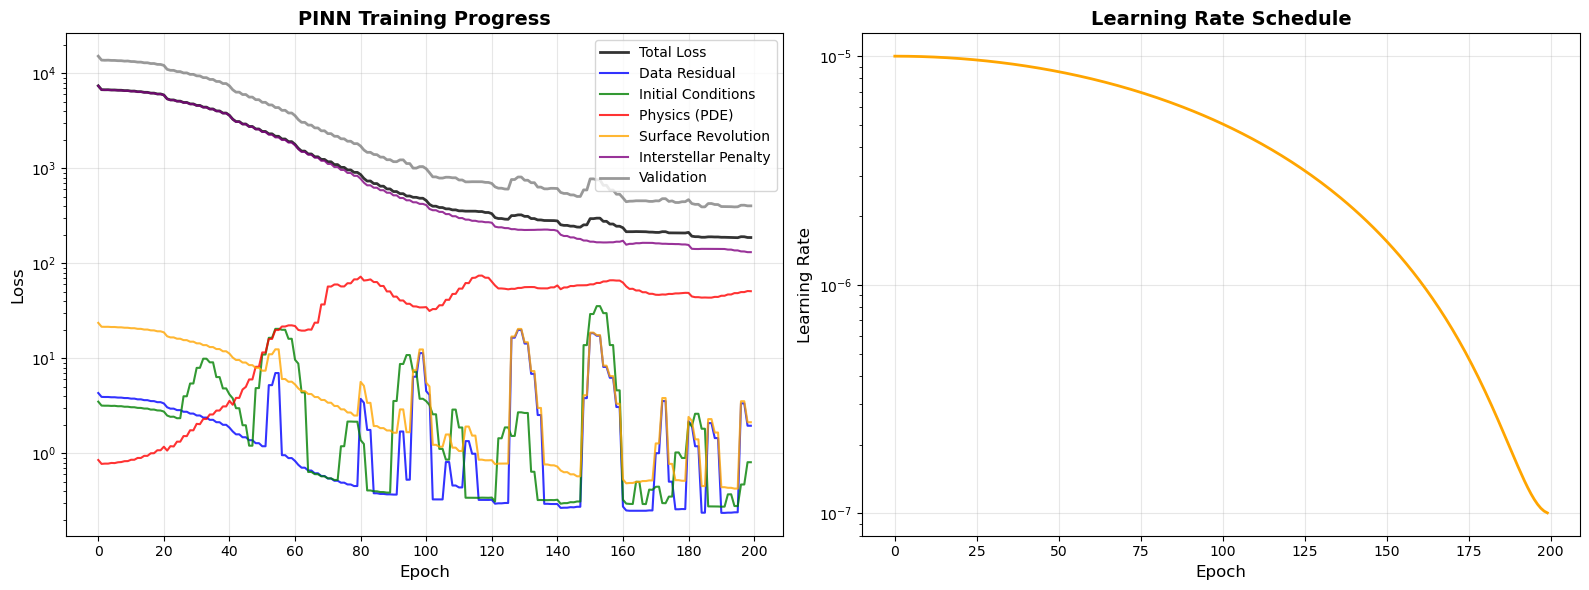

🎯 Final Training Results:
  Total Loss: 1.8708e+02
  Validation Loss: 4.0326e+02
  Data Residual: 1.9526e+00
  Physics Loss: 5.0940e+01
  Recent Improvement Rate: 81.5%
  🔄 Training still improving - consider more epochs


In [ ]:
# ===============================================================================
# TRAINING RESULTS VISUALIZATION
# ===============================================================================

# Get training history
(total_loss, loss_IC, loss_PDE, loss_residual, 
 loss_interstellar, loss_surface_revolution, loss_validation) = model.get_training_history()

# Create enhanced loss plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Main loss plot
loss_components = [
    (total_loss, 'Total Loss', 'black', 2.0),
    (loss_residual, 'Data Residual', 'blue', 1.5),
    (loss_IC, 'Initial Conditions', 'green', 1.5),
    (loss_PDE, 'Physics (PDE)', 'red', 1.5),
    (loss_surface_revolution, 'Surface Revolution', 'orange', 1.5),
    (loss_interstellar, 'Interstellar Penalty', 'purple', 1.5),
    (loss_validation, 'Validation', 'gray', 2.0)
]

for loss_data, label, color, width in loss_components:
    if len(loss_data) > 0:
        ax1.plot(loss_data.flatten(), label=label, color=color, linewidth=width, alpha=0.8)

# Formatting for main plot
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_yscale('log')
ax1.set_title('PINN Training Progress', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10, loc='upper right')

# Set x-axis ticks
max_epochs = len(total_loss) if len(total_loss) > 0 else config['epochs']
tick_spacing = max(1, max_epochs // 10)
ax1.set_xticks(np.arange(0, max_epochs + 1, tick_spacing))

# Learning rate plot (if available)
if hasattr(model, 'scheduler'):
    # Simulate LR schedule for visualization
    lrs = []
    temp_optimizer = torch.optim.AdamW([torch.tensor(1.0)], lr=config['learning_rate'])
    temp_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        temp_optimizer, T_max=max_epochs, eta_min=config['learning_rate'] * 0.01
    )
    
    for _ in range(max_epochs):
        lrs.append(temp_optimizer.param_groups[0]['lr'])
        temp_optimizer.step()
        temp_scheduler.step()
    
    ax2.plot(lrs, color='orange', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Learning Rate', fontsize=12)
    ax2.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale('log')

plt.tight_layout()
plt.show()

# Print final results
if len(total_loss) > 0:
    print(f"🎯 Final Training Results:")
    print(f"  Total Loss: {total_loss[-1].item():.4e}")
    if len(loss_validation) > 0:
        print(f"  Validation Loss: {loss_validation[-1].item():.4e}")
    if len(loss_residual) > 0:
        print(f"  Data Residual: {loss_residual[-1].item():.4e}")
    if len(loss_PDE) > 0:
        print(f"  Physics Loss: {loss_PDE[-1].item():.4e}")
    
    # Convergence analysis
    if len(total_loss) > 100:
        recent_avg = np.mean([x.item() for x in total_loss[-50:]])
        early_avg = np.mean([x.item() for x in total_loss[50:100]])
        improvement_rate = (early_avg - recent_avg) / early_avg * 100
        print(f"  Recent Improvement Rate: {improvement_rate:.1f}%")
        
        if improvement_rate < 1.0:
            print("  📈 Training appears to have converged!")
        else:
            print("  🔄 Training still improving - consider more epochs")

Validation predictions shape: torch.Size([2472, 2])
Validation targets shape: torch.Size([2472, 2])


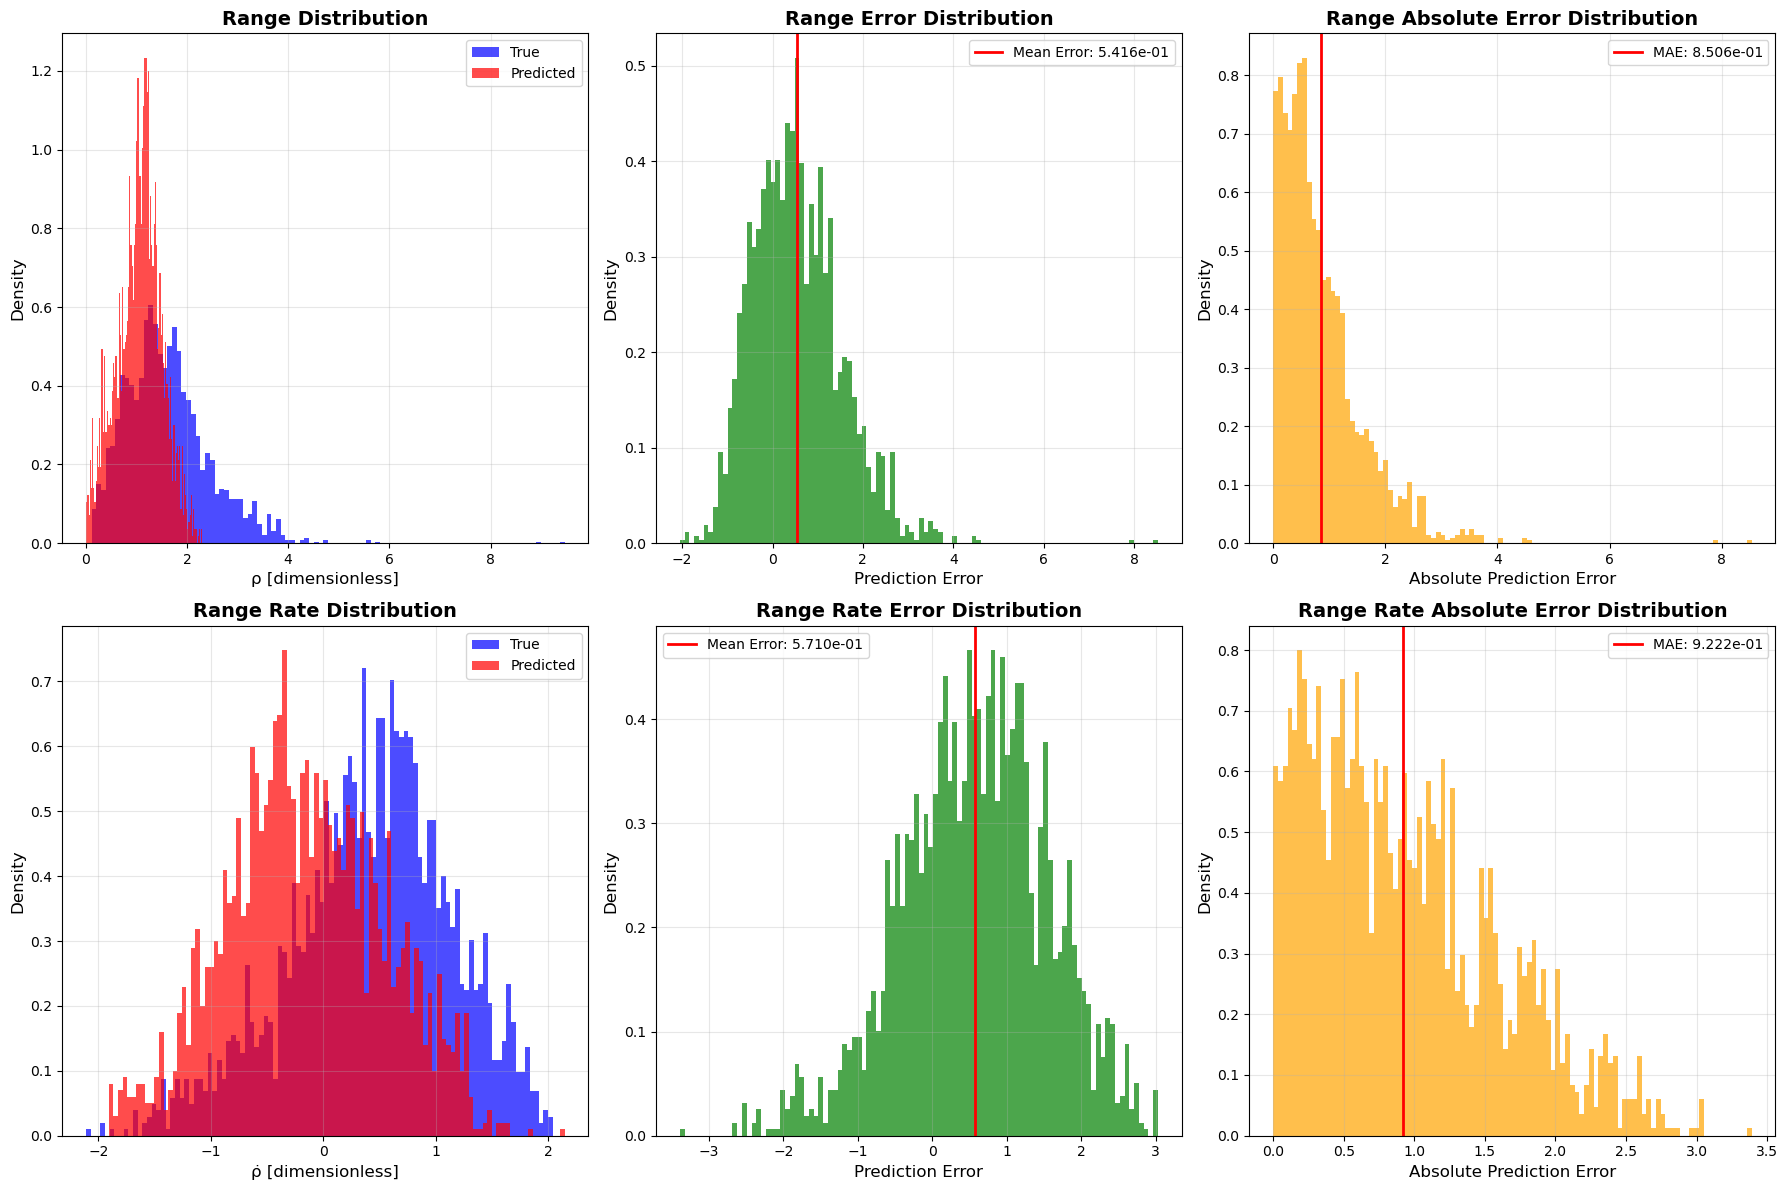


📊 Detailed Error Analysis:
  Range (ρ) Errors:
    Mean Error: 5.415651e-01
    Std Error: 9.832582e-01
    Min Error: -2.052630e+00
    Max Error: 8.530281e+00
    Error Range: 1.058291e+01

  Range Rate (ρ̇) Errors:
    Mean Error: 5.710402e-01
    Std Error: 9.791883e-01
    Min Error: -3.389409e+00
    Max Error: 3.030966e+00
    Error Range: 6.420375e+00

📈 Error Distribution Analysis:
  Range Error Normality Test (Shapiro-Wilk):
    p-value: 0.000000 (Non-normal distribution)
  Range Rate Error Normality Test (Shapiro-Wilk):
    p-value: 0.000000 (Non-normal distribution)

📊 Error Percentiles:
  Range (ρ) Error Percentiles:
    5th: 6.537478e-02
    25th: 3.289641e-01
    50th (Median): 6.530945e-01
    75th: 1.156868e+00
    95th: 2.294841e+00

  Range Rate (ρ̇) Error Percentiles:
    5th: 8.499520e-02
    25th: 3.811456e-01
    50th (Median): 8.023360e-01
    75th: 1.327694e+00
    95th: 2.200600e+00


In [ ]:
# Get model predictions on validation set
with torch.no_grad():
    y_pred = model.network_prediction(model.t_valid, model.x_valid).detach().cpu()
    
print(f"Validation predictions shape: {y_pred.shape}")
print(f"Validation targets shape: {model.y_valid.shape}")

# ===============================================================================
# HISTOGRAM VISUALIZATION OF VALIDATION RESULTS
# ===============================================================================


# Denormalize predictions and validation data for plotting
t_valid_np = denormalize(model.t_valid, t_mins, t_maxs).detach().cpu().numpy()
y_valid_np = denormalize(model.y_valid, y_mins, y_maxs).detach().cpu().numpy()
y_pred_np = denormalize(y_pred, y_mins, y_maxs).numpy()

n_bins = 100

# Calculate errors for histogram analysis
error_rho = y_valid_np[:, 0] - y_pred_np[:, 0]
error_rho_dot = y_valid_np[:, 1] - y_pred_np[:, 1]

# Create comprehensive histogram plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: Range (ρ) analysis
# Distribution comparison
axes[0, 0].hist(y_valid_np[:, 0], bins=n_bins, alpha=0.7, label='True', color='blue', density=True)
axes[0, 0].hist(y_pred_np[:, 0], bins=n_bins, alpha=0.7, label='Predicted', color='red', density=True)
axes[0, 0].set_xlabel('ρ [dimensionless]', fontsize=12)
axes[0, 0].set_ylabel('Density', fontsize=12)
axes[0, 0].set_title('Range Distribution', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10, loc='upper right')
axes[0, 0].grid(True, alpha=0.3)

# Error histogram
axes[0, 1].hist(error_rho, bins=n_bins, alpha=0.7, color='green', density=True)
axes[0, 1].axvline(np.mean(error_rho), color='red', linestyle='-', linewidth=2, label=f'Mean Error: {np.mean(error_rho):.3e}')
axes[0, 1].set_xlabel('Prediction Error', fontsize=12)
axes[0, 1].set_ylabel('Density', fontsize=12)
axes[0, 1].set_title('Range Error Distribution', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Absolute error histogram
axes[0, 2].hist(np.abs(error_rho), bins=n_bins, alpha=0.7, color='orange', density=True)
axes[0, 2].axvline(np.mean(np.abs(error_rho)), color='red', linestyle='-', linewidth=2, 
                   label=f'MAE: {np.mean(np.abs(error_rho)):.3e}')
axes[0, 2].set_xlabel('Absolute Prediction Error', fontsize=12)
axes[0, 2].set_ylabel('Density', fontsize=12)
axes[0, 2].set_title('Range Absolute Error Distribution', fontsize=14, fontweight='bold')
axes[0, 2].legend(fontsize=10)
axes[0, 2].grid(True, alpha=0.3)

# Row 2: Range Rate (ρ̇) analysis
# Distribution comparison
axes[1, 0].hist(y_valid_np[:, 1], bins=n_bins, alpha=0.7, label='True', color='blue', density=True)
axes[1, 0].hist(y_pred_np[:, 1], bins=n_bins, alpha=0.7, label='Predicted', color='red', density=True)
axes[1, 0].set_xlabel('ρ̇ [dimensionless]', fontsize=12)
axes[1, 0].set_ylabel('Density', fontsize=12)
axes[1, 0].set_title('Range Rate Distribution', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10, loc='upper right')
axes[1, 0].grid(True, alpha=0.3)

# Error histogram
axes[1, 1].hist(error_rho_dot, bins=n_bins, alpha=0.7, color='green', density=True)
axes[1, 1].axvline(np.mean(error_rho_dot), color='red', linestyle='-', linewidth=2, 
                   label=f'Mean Error: {np.mean(error_rho_dot):.3e}')
axes[1, 1].set_xlabel('Prediction Error', fontsize=12)
axes[1, 1].set_ylabel('Density', fontsize=12)
axes[1, 1].set_title('Range Rate Error Distribution', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

# Absolute error histogram
axes[1, 2].hist(np.abs(error_rho_dot), bins=n_bins, alpha=0.7, color='orange', density=True)
axes[1, 2].axvline(np.mean(np.abs(error_rho_dot)), color='red', linestyle='-', linewidth=2, 
                   label=f'MAE: {np.mean(np.abs(error_rho_dot)):.3e}')
axes[1, 2].set_xlabel('Absolute Prediction Error', fontsize=12)
axes[1, 2].set_ylabel('Density', fontsize=12)
axes[1, 2].set_title('Range Rate Absolute Error Distribution', fontsize=14, fontweight='bold')
axes[1, 2].legend(fontsize=10)
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical summary of errors
print(f"\n📊 Detailed Error Analysis:")
print(f"  Range (ρ) Errors:")
print(f"    Mean Error: {np.mean(error_rho):.6e}")
print(f"    Std Error: {np.std(error_rho):.6e}")
print(f"    Min Error: {np.min(error_rho):.6e}")
print(f"    Max Error: {np.max(error_rho):.6e}")
print(f"    Error Range: {np.max(error_rho) - np.min(error_rho):.6e}")

print(f"\n  Range Rate (ρ̇) Errors:")
print(f"    Mean Error: {np.mean(error_rho_dot):.6e}")
print(f"    Std Error: {np.std(error_rho_dot):.6e}")
print(f"    Min Error: {np.min(error_rho_dot):.6e}")
print(f"    Max Error: {np.max(error_rho_dot):.6e}")
print(f"    Error Range: {np.max(error_rho_dot) - np.min(error_rho_dot):.6e}")

# Distribution tests
from scipy import stats

# Normality tests for errors
_, p_rho_normal = stats.shapiro(error_rho)
_, p_rho_dot_normal = stats.shapiro(error_rho_dot)

print(f"\n📈 Error Distribution Analysis:")
print(f"  Range Error Normality Test (Shapiro-Wilk):")
print(f"    p-value: {p_rho_normal:.6f} ({'Normal' if p_rho_normal > 0.05 else 'Non-normal'} distribution)")
print(f"  Range Rate Error Normality Test (Shapiro-Wilk):")
print(f"    p-value: {p_rho_dot_normal:.6f} ({'Normal' if p_rho_dot_normal > 0.05 else 'Non-normal'} distribution)")

# Percentile analysis
print(f"\n📊 Error Percentiles:")
print(f"  Range (ρ) Error Percentiles:")
print(f"    5th: {np.percentile(np.abs(error_rho), 5):.6e}")
print(f"    25th: {np.percentile(np.abs(error_rho), 25):.6e}")
print(f"    50th (Median): {np.percentile(np.abs(error_rho), 50):.6e}")
print(f"    75th: {np.percentile(np.abs(error_rho), 75):.6e}")
print(f"    95th: {np.percentile(np.abs(error_rho), 95):.6e}")

print(f"\n  Range Rate (ρ̇) Error Percentiles:")
print(f"    5th: {np.percentile(np.abs(error_rho_dot), 5):.6e}")
print(f"    25th: {np.percentile(np.abs(error_rho_dot), 25):.6e}")
print(f"    50th (Median): {np.percentile(np.abs(error_rho_dot), 50):.6e}")
print(f"    75th: {np.percentile(np.abs(error_rho_dot), 75):.6e}")
print(f"    95th: {np.percentile(np.abs(error_rho_dot), 95):.6e}")

🔧 CONVERTING PREDICTIONS TO PHYSICAL UNITS FOR PLOTTING:
Min MJD: 50400.3
Max MJD: 60864.113


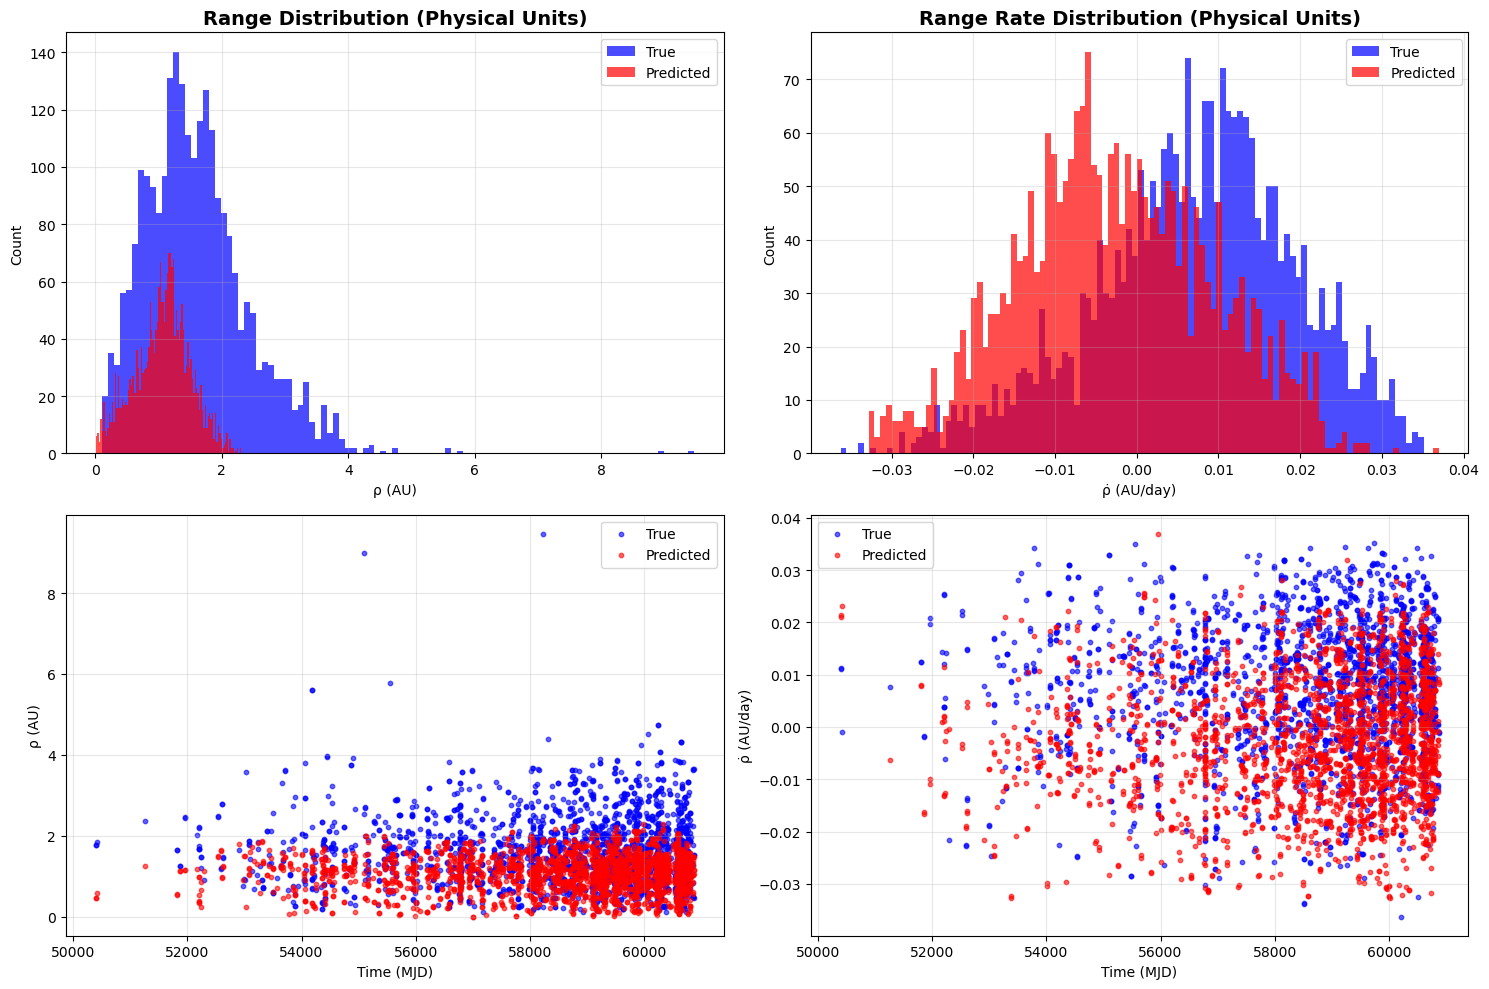


📊 ERROR ANALYSIS (Physical Units):
Range (ρ) errors:
  Mean absolute error: 0.850595 AU
  Max error: 8.530402 AU
  Relative error: 53.03%

Range rate (ρ̇) errors:
  Mean absolute error: 0.015863 AU/day
  Max error: 0.058305 AU/day
  Relative error: 134.12%


In [ ]:
# ===============================================================================
# PLOT WITH CONVERTED PREDICTIONS TO PHYSICAL UNITS
# ===============================================================================

print("🔧 CONVERTING PREDICTIONS TO PHYSICAL UNITS FOR PLOTTING:")
print("=" * 70)

# Get the validation indices to extract corresponding original time values
val_size = len(y_valid_np)
val_indices = torch.arange(len(t_allN) - val_size, len(t_allN))  # Last val_size points
t_valid_original = t_allN[val_indices].cpu().numpy().flatten()  # Original MJD values

print("Min MJD:", t_valid_original.min())
print("Max MJD:", t_valid_original.max())

y_pred_physical = np.zeros_like(y_pred_np)
y_pred_physical[:, 0] = (y_pred_np[:, 0] * L_c) / AU  # Convert rho back to AU
y_pred_physical[:, 1] = (y_pred_np[:, 1] * V_c * DAY) / AU  # Convert rho_dot back to AU/day

y_valid_physical = np.zeros_like(y_valid_np)
y_valid_physical[:, 0] = (y_valid_np[:, 0] * L_c) / AU
y_valid_physical[:, 1] = (y_valid_np[:, 1] * V_c * DAY) / AU

# Now create the plot with both in physical units
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Top-left: Range Distribution Comparison (both in AU)
axes[0, 0].hist(y_valid_physical[:, 0], bins=n_bins, alpha=0.7, label='True', color='blue')
axes[0, 0].hist(y_pred_physical[:, 0], bins=n_bins, alpha=0.7, label='Predicted', color='red')
axes[0, 0].set_xlabel('ρ (AU)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Range Distribution (Physical Units)', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Top-right: Range Rate Distribution Comparison (both in AU/day)
axes[0, 1].hist(y_valid_physical[:, 1], bins=n_bins, alpha=0.7, label='True', color='blue')
axes[0, 1].hist(y_pred_physical[:, 1], bins=n_bins, alpha=0.7, label='Predicted', color='red')
axes[0, 1].set_xlabel('ρ̇ (AU/day)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Range Rate Distribution (Physical Units)', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Bottom-left: Range vs Time (both in physical units)
axes[1, 0].scatter(t_valid_original, y_valid_physical[:, 0], alpha=0.6, s=10, color='blue', label='True')
axes[1, 0].scatter(t_valid_original, y_pred_physical[:, 0], alpha=0.6, s=10, color='red', label='Predicted')
axes[1, 0].set_xlabel('Time (MJD)')
axes[1, 0].set_ylabel('ρ (AU)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Bottom-right: Range Rate vs Time (both in physical units)
axes[1, 1].scatter(t_valid_original, y_valid_physical[:, 1], alpha=0.6, s=10, color='blue', label='True')
axes[1, 1].scatter(t_valid_original, y_pred_physical[:, 1], alpha=0.6, s=10, color='red', label='Predicted')
axes[1, 1].set_xlabel('Time (MJD)')
axes[1, 1].set_ylabel('ρ̇ (AU/day)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate meaningful error metrics in physical units
rho_error = np.abs(y_pred_physical[:, 0] - y_valid_physical[:, 0])
rho_dot_error = np.abs(y_pred_physical[:, 1] - y_valid_physical[:, 1])

print(f"\n📊 ERROR ANALYSIS (Physical Units):")
print(f"Range (ρ) errors:")
print(f"  Mean absolute error: {rho_error.mean():.6f} AU")
print(f"  Max error: {rho_error.max():.6f} AU")
print(f"  Relative error: {(rho_error.mean() / y_valid_physical[:, 0].mean()) * 100:.2f}%")

print(f"\nRange rate (ρ̇) errors:")
print(f"  Mean absolute error: {rho_dot_error.mean():.6f} AU/day")
print(f"  Max error: {rho_dot_error.max():.6f} AU/day")
print(f"  Relative error: {(rho_dot_error.mean() / np.abs(y_valid_physical[:, 1]).mean()) * 100:.2f}%")